# Ising model

Here we consider inference on an Ising model.
First we import the code and set some plotting parameters.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time
sys.path.insert(1, '../../src/')
from discrete_mixflows import *
from gibbs import *
from concrete import *
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='../../../discrete-ergodic-flows-tex/fig/'

## 1D model

The one dimensional Ising model considers a target distribution $\pi(x)$
on $\mathcal{X}=\{-1,1\}^M$ such that
$$
    \pi(x)\propto\exp\left\{\beta\sum_{m=1}^{M-1} x_m x_{m+1}\right\},
$$
where $\beta>0$ is an inverse temperature parameter.
The normalizing constant is generally intractable since it involves a sum over $2^M$ terms
but the full conditionals $\pi_m$ can be calculated in closed form.
Specifically, for the particles $x_1$ and $x_M$ the full conditional
only depends on their only neighbors:
$$
    \pi_1(x)=\frac{\exp(\beta x x_2)}{2\cosh(\beta)},\qquad
    \pi_M(x)=\frac{\exp(\beta x x_{M-1})}{2\cosh(\beta)}.
$$
The normalizing constant is tractable since it involves adding over two terms only
and can be simplified since $\cosh(\beta)=\cosh(-\beta)$.
The probability for particles with two neighbors 
$x_m,  m\neq1,M$ is likewise given by
$$
    \pi_m(x)=\frac{\exp(\beta x (x_{m-1} + x_{m+1}))}{2\cosh(\beta (x_{m-1}+x_{m+1}))}.
$$

We consider an instantiation with $M=5$ particles
that starts at a uniform distribution over the $2^M$ possible arrangements.
For simplicity, we consider an inverse temperature of $\beta=1$.

In [75]:
########################
########################
# target specification #
########################
########################
M=5 # number of particles

# target
beta=1. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [76]:
x=idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)
prbs_smallM=np.copy(prbs)
smallM=5

In [77]:
########################
########################
#    Mad Mix approx    #
########################
########################
madmix_elbos = -np.inf*np.ones(2)
madmix_cput  =  np.inf*np.ones(2)

# reference specification
lq0 = lambda x,u : -M*np.log(2)*np.ones(x.shape[1])
def randq0(size): 
    tmpx=np.random.randint(low=0,high=2,size=(M,size))
    return tmpx,np.random.rand(M,size)

# settings
N=1000
xi=np.pi/16
x=idx_unflattenBinary(np.arange(0,2**M),M)

In [78]:
t0=time.perf_counter()
qvar_smallM=np.exp(lqN(x,np.random.rand(M,2**M),N=N,lq0=lq0,lp=lp,xi=xi))
madmix_cput[0]=time.perf_counter()-t0

In [79]:
# compute ELBO
elbo_qN_smallM=elbo_exact(np.log(qvar_smallM/np.sum(qvar_smallM)),np.log(prbs_smallM))
madmix_elbos[0]=elbo_qN_smallM

In [80]:
########################
########################
#    Gibbs sampling    #
########################
########################
gibbs_elbos = -np.inf*np.ones(2)
gibbs_cput  =  np.inf*np.ones(2)

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

t0=time.perf_counter()
gibbs_samples_smallM=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,verbose=True)
gibbs_cput[0]=time.perf_counter()-t0

In [81]:
# get density and compute ELBO
gibbs_density_smallM=plt.hist(idx_flattenBinary(gibbs_samples_smallM),bins=np.arange(0,2**M+1),density=True)[0]
gibbs_density_smallM[gibbs_density_smallM<1e-32]=1e-32
gibbs_density_smallM=gibbs_density_smallM/np.sum(gibbs_density_smallM)
plt.clf()
elbo_gibbs_smallM=elbo_exact(np.log(gibbs_density_smallM),np.log(prbs_smallM))
gibbs_elbos[0]=elbo_gibbs_smallM

<Figure size 1500x750 with 0 Axes>

In [44]:
########################
########################
#       Concrete       #
########################
########################
flows_smallM     = pkl_load('sockeye/smallM/ising_flows')
losses_smallM    = pkl_load('sockeye/smallM/ising_losses')
cpu_times_smallM = pkl_load('sockeye/smallM/ising_cpu_times')
sim_size_smallM  = len(flows_smallM)
max_iters_smallM = losses_smallM.shape[-1]
print('Total training time: '+str(cpu_times_smallM.sum()/3600)+' hours')

Total training time: 141.52918395412144 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

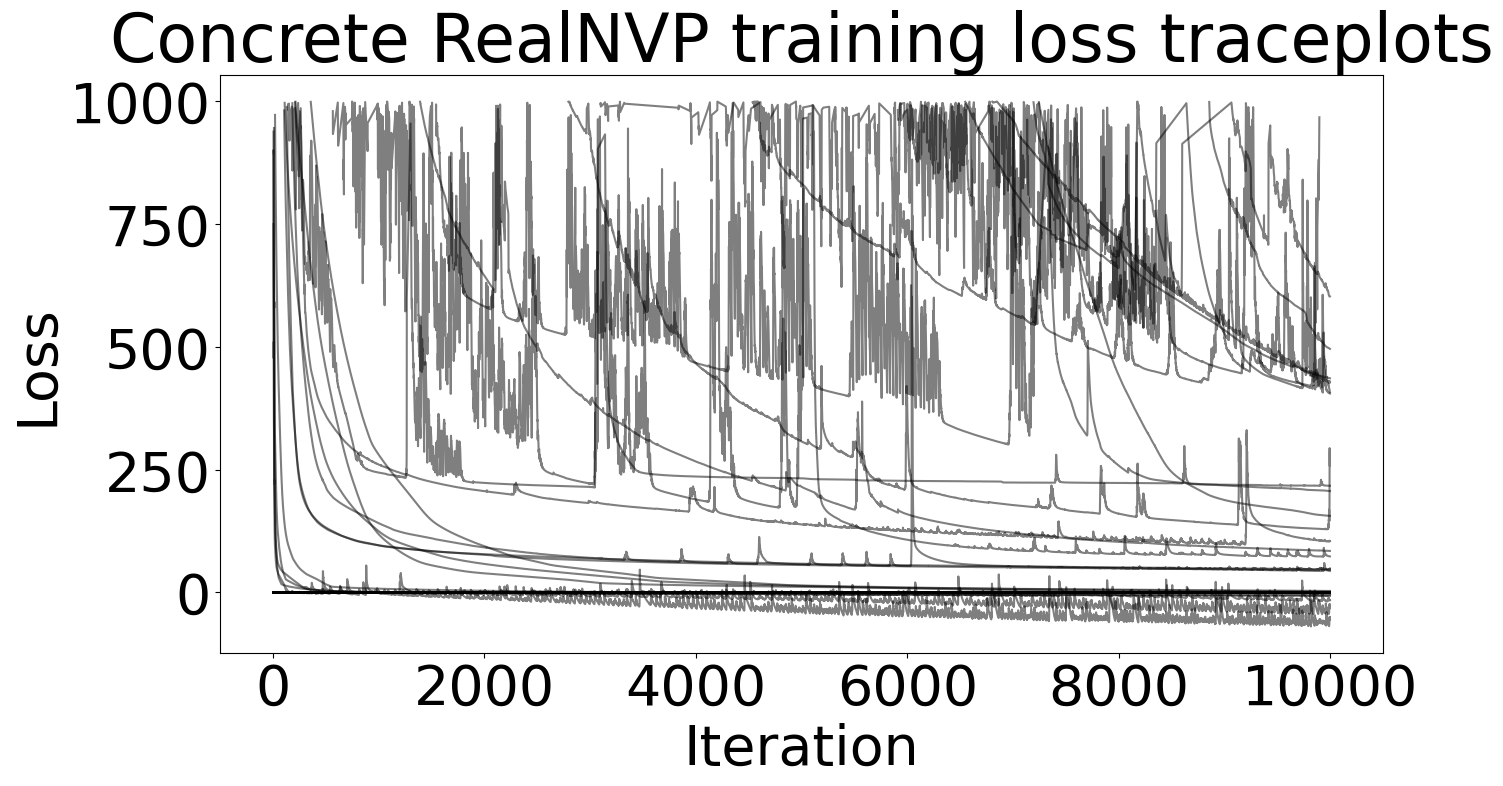

In [45]:
# loss traceplot
threshold=1000
for i in range(sim_size_smallM): plt.plot(np.arange(max_iters_smallM)[losses_smallM[i,:]<threshold],losses_smallM[i,losses_smallM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [50]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples_smallM=np.zeros((sim_size_smallM,M,sample_size))
densities_smallM=np.zeros((sim_size_smallM,2**M))
elbos_smallM=-np.inf*np.ones(sim_size_smallM)

for i in range(sim_size_smallM):
    print(str(i+1)+'/'+str(sim_size_smallM),end='\r')
    tmp_flow=flows_smallM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflattenBinary(tmp_sample,M) # 1d->2d
    samples_smallM[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample),bins=np.arange(0,2**M+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    tmp_density=tmp_density/np.sum(tmp_density)
    densities_smallM[i,:]=tmp_density
    
    # estimate elbo
    elbos_smallM[i]=elbo_exact(np.log(tmp_density),np.log(prbs_smallM))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_29600/3794995460.py:19: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_29600/3794995460.py:20: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1500x750 with 0 Axes>

In [51]:
i_star=np.argmax(elbos_smallM)
print('Optimal flow: '+str(i_star))

Optimal flow: 112


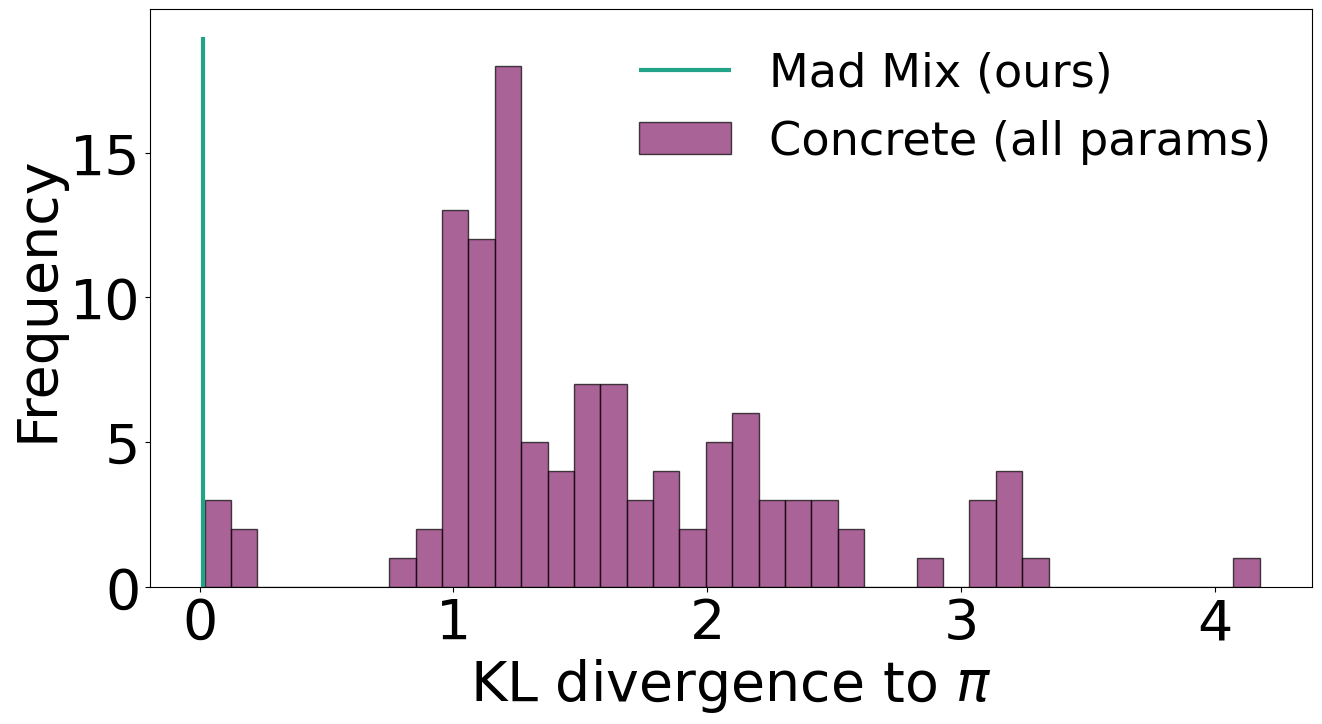

In [94]:
plt.vlines(-elbo_qN_smallM,ymin=0,ymax=19,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos_smallM[-elbos_smallM<5],bins=40,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)
plt.savefig(fig_path+'ising_smallM_elbos.pdf', dpi=300, bbox_inches='tight')

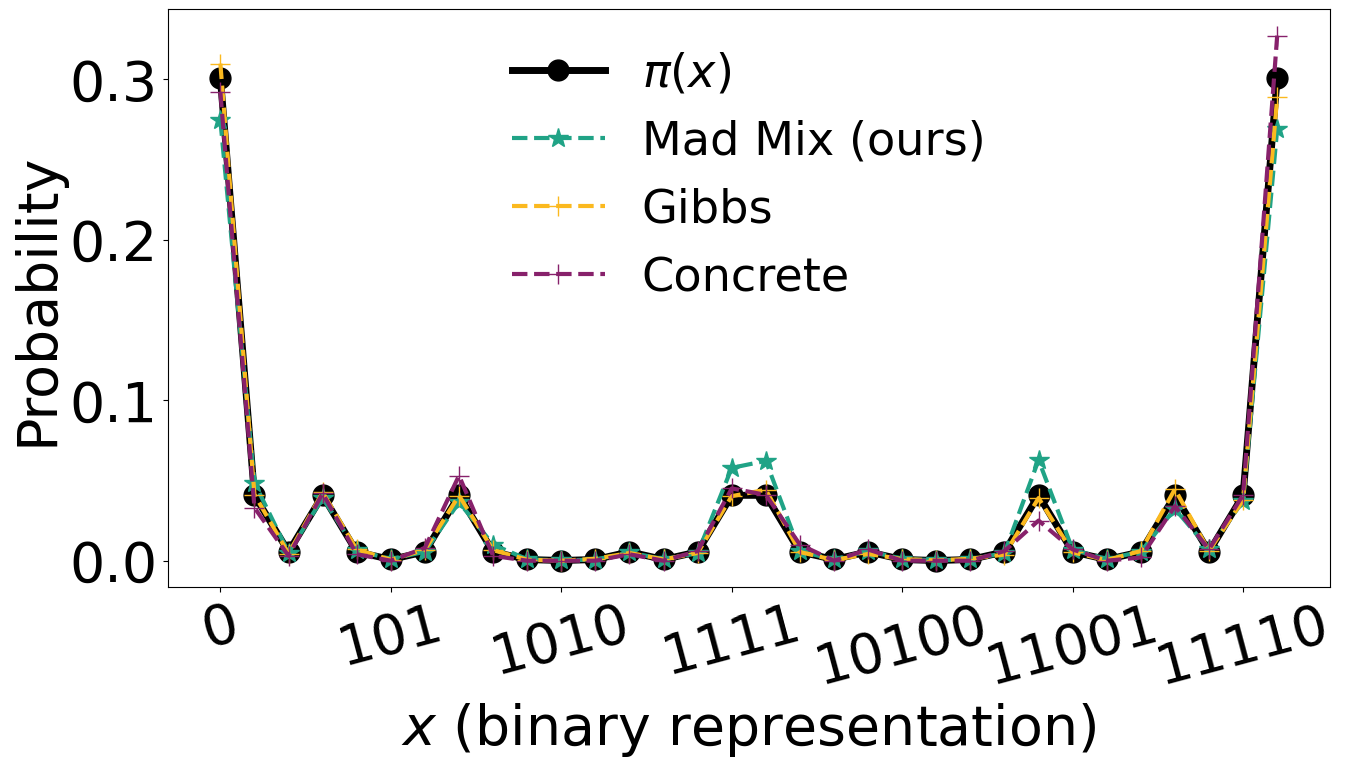

In [53]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,2**smallM)
plt.plot(ttx+0.5,prbs_smallM,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar_smallM/np.sum(qvar_smallM),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,gibbs_density_smallM,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,densities_smallM[np.argmax(elbos_smallM),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel('$x$ (binary representation)')
plt.xticks(ticks=np.arange(0,2**smallM,step=smallM)+0.5,
           labels=[np.binary_repr(t) for t in np.arange(0,2**smallM,step=smallM)],
          rotation=15)
plt.ylabel('Probability')
plt.savefig(fig_path+'ising_smallM_prbs.pdf', dpi=300, bbox_inches='tight')

In [54]:
print('ELBO(qN||π)='+str(elbo_qN_smallM))
print('ELBO(qGibbs||π)='+str(elbo_gibbs_smallM))
print('ELBO(qConcrete_opt||π)='+str(elbos_smallM[np.argmax(elbos_smallM)]))

ELBO(qN||π)=-0.020628027180603217
ELBO(qGibbs||π)=-0.002687997273457369
ELBO(qConcrete_opt||π)=-0.02010118478443335


# 1D Ising with a large M

Now we consider an Ising model where $M=12$,
which results in parameter space of dimension $2^{12}=4,096$.
We also consider an inverse temperature of 2,
which results in a bimodal distribution $\pi$
with modes at the extrema: 
either $x_m=-1$ for all $m$ or $x_m=+1$ for all $m$.

We run a Gibbs sampler
and a RealNVP flow with a Concrete approximation
both starting at a uniform distribution.
For MadMix, we consider a mixture of two flows,
each initialized at each of the extrema
(with truncated Poisson probabilities to prevent leaking).
We then optimize the weights of the mixture of MadMix flows
by minimizing the reverse KL to the target.

In [95]:
########################
########################
# target specification #
########################
########################
M=50 # number of particles

# target
beta=2. # temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [96]:
length=5
x1=np.arange(0,length)
x2=np.arange(2**M-length,2**M)
x=np.hstack((x1,x2))
lprbs=lp(idx_unflattenBinary(x,M))
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)
plt_lprbs=np.log(prbs)-np.amin(np.log(prbs))

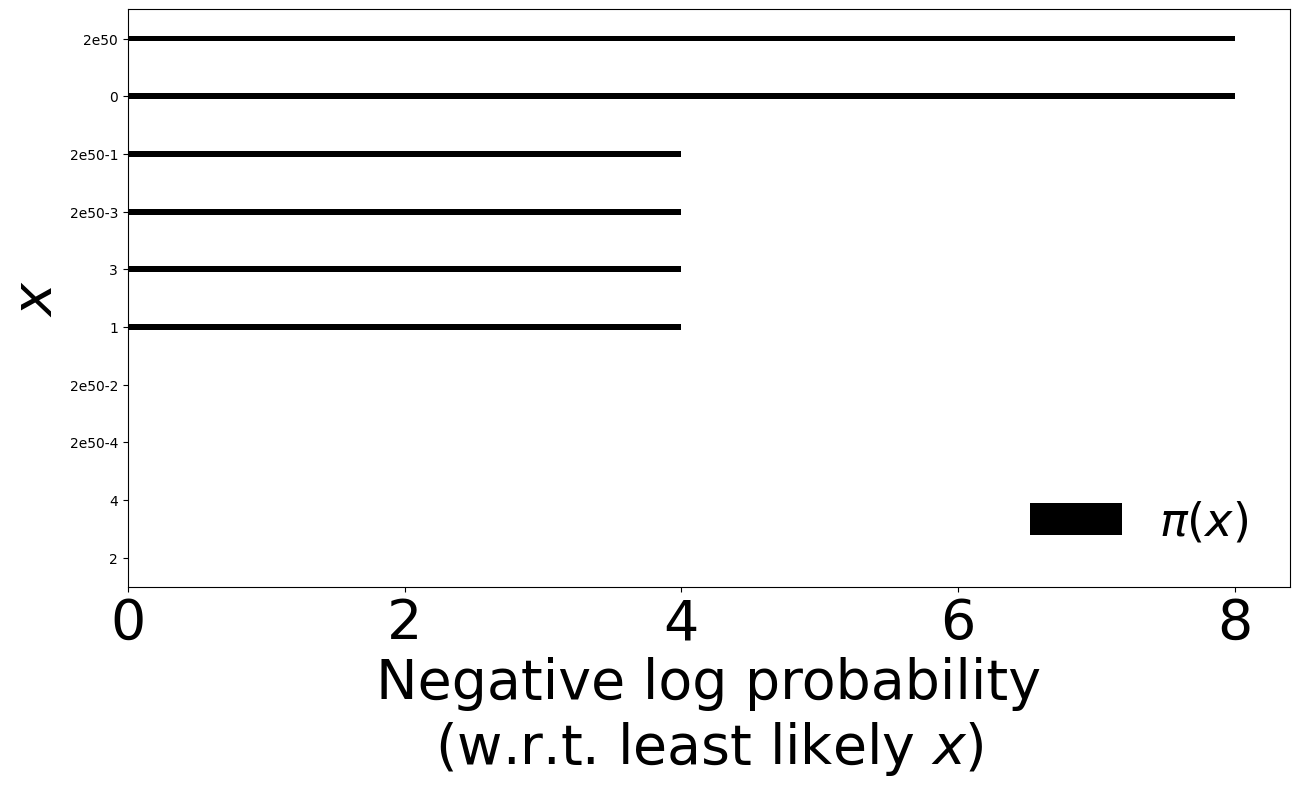

In [97]:
x1_labs=[str(x1[i]) for i in range(x1.shape[0])]
x2_labs=['2e50-'+str(x2.shape[0]-i-1) for i in range(x2.shape[0])]
x2_labs[-1]='2e50'
x_labs=np.hstack((x1_labs,np.array(x2_labs)))
sort_idx=np.argsort(prbs)
ticks=np.arange(0,lprbs.shape[0],step=length/5)
#ticks_labs=x[sort_idx]
ticks_labs=x_labs[sort_idx]

plt.barh(np.arange(0,lprbs.shape[0]),plt_lprbs[sort_idx],height=0.1,label='$\pi(x)$',
        color='black',lw=0)
plt.yticks(ticks=ticks,
           labels=ticks_labs[ticks.astype(int)],
           fontsize=10)
plt.xlabel('Negative log probability\n(w.r.t. least likely $x$)')
plt.ylabel(r'$x$')
plt.legend(frameon=False,fontsize='small',loc='lower right')

## KL-optimal weighting

In [107]:
###############################
###############################
# variational family settings #
###############################
###############################
RUN=False # false to load cached results, True to run everything
t0=time.perf_counter()

# reference specification
poiss_lambda=2.
p0=stats.poisson.pmf(np.arange(0,2**5),mu=poiss_lambda) # assign probs close to all 0's
p0[p0<0.05]=1e-64
p0=p0/np.sum(p0)
p1=np.flip(p0) # assign probs close to all 1's
def lq0_0(x,u):
    flat_x=idx_flattenBinary(x)
    out=np.log(1e-32*np.ones(flat_x.shape[0]))
    out[flat_x<2**5]=np.log(p0[flat_x[flat_x<2**5]])
    return out

def lq0_1(x,u):
    flat_x=idx_flattenBinary(1-x) # swap indices
    out=np.log(1e-32*np.ones(flat_x.shape[0]))
    out[flat_x<2**5]=np.log(p0[flat_x[flat_x<2**5]])
    return out


# settings
N0=100
N1=100
xi=np.pi/16

# mixture variational approximation
fixed_u=0.5*np.ones((M,x.shape[0]))
lq0 = lambda x : lqN(x,fixed_u,N0,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,fixed_u,N1,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))
def lq_fixed(w):
    exp1=lq0_fixed+np.log(w)
    exp2=lq1_fixed+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))

# init x grid and fixed densities
if RUN:
    lq0_fixed=lq0(idx_unflattenBinary(x,M))
    aux.pkl_save(lq0_fixed,'madmix_cache/lq0_fixed')
    
    lq1_fixed=lq1(idx_unflattenBinary(x,M))
    aux.pkl_save(lq1_fixed,'madmix_cache/lq1_fixed')
    
    madmix_cput[1]=time.perf_counter()-t0
    aux.pkl_save(madmix_cput,'madmix_cache/madmix_cput')
else:
    lq0_fixed=aux.pkl_load('madmix_cache/lq0_fixed')
    lq1_fixed=aux.pkl_load('madmix_cache/lq1_fixed')
    madmix_cput=aux.pkl_load('madmix_cache/madmix_cput')

In [104]:
#ttx=np.arange(0,x.shape[0])
#plt.plot(ttx,lq0_fixed)
#plt.plot(ttx,lq1_fixed)

In [108]:
######################
######################
#    optimization    #
######################
######################
t0=time.perf_counter()

# optimization settings
np.random.seed(2023)
max_iter=10001
gamma=1e0
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    #gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq(x,w)-lp(x))) # unfixed x
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq_fixed(w)-np.log(prbs))) # with fixed x
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    if t%(max_iter//10)==0: print('  '+str(t)+'   | '+str(w)+'  | '+str(gradient))
# end for
madmix_cput[1]=madmix_cput[1]+time.perf_counter()-t0

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  0   | 0.4185659936958214  | -0.09657768970385366
  1000   | 0.49999999999999856  | -7.494005416219807e-16
  2000   | 0.49999999999999856  | -7.494005416219807e-16
  3000   | 0.49999999999999856  | -7.494005416219807e-16
  4000   | 0.49999999999999856  | -7.494005416219807e-16
  5000   | 0.49999999999999856  | -7.494005416219807e-16
  6000   | 0.49999999999999856  | -7.494005416219807e-16
  7000   | 0.49999999999999856  | -7.494005416219807e-16
  8000   | 0.49999999999999856  | -7.494005416219807e-16
  9000   | 0.49999999999999856  | -7.494005416219807e-16
  10000   | 0.49999999999999856  | -7.494005416219807e-16


In [109]:
t0=time.perf_counter()
#weighted_q=np.exp(lq(x,w))
weighted_q=np.exp(lq_fixed(w))
weighted_q=weighted_q/np.sum(weighted_q)
aux.pkl_save(weighted_q,'madmix_cache/weighted_q')

madmix_cput[1]=madmix_cput[1]+time.perf_counter()-t0

In [101]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

t0=time.perf_counter()
gibbs_samples=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,switch=True,verbose=True)
gibbs_cput[1]=time.perf_counter()-t0

TypeError: gibbs_sampler() got an unexpected keyword argument 'switch'

In [90]:
# get density
gibbs_density=(idx_flattenBinary(gibbs_samples)[:,np.newaxis]==x[np.newaxis,:]).astype(int).sum(axis=0)
gibbs_density=gibbs_density/np.sum(gibbs_density)
gibbs_density[gibbs_density<1e-8]=1e-8
gibbs_density=gibbs_density/np.sum(gibbs_density)

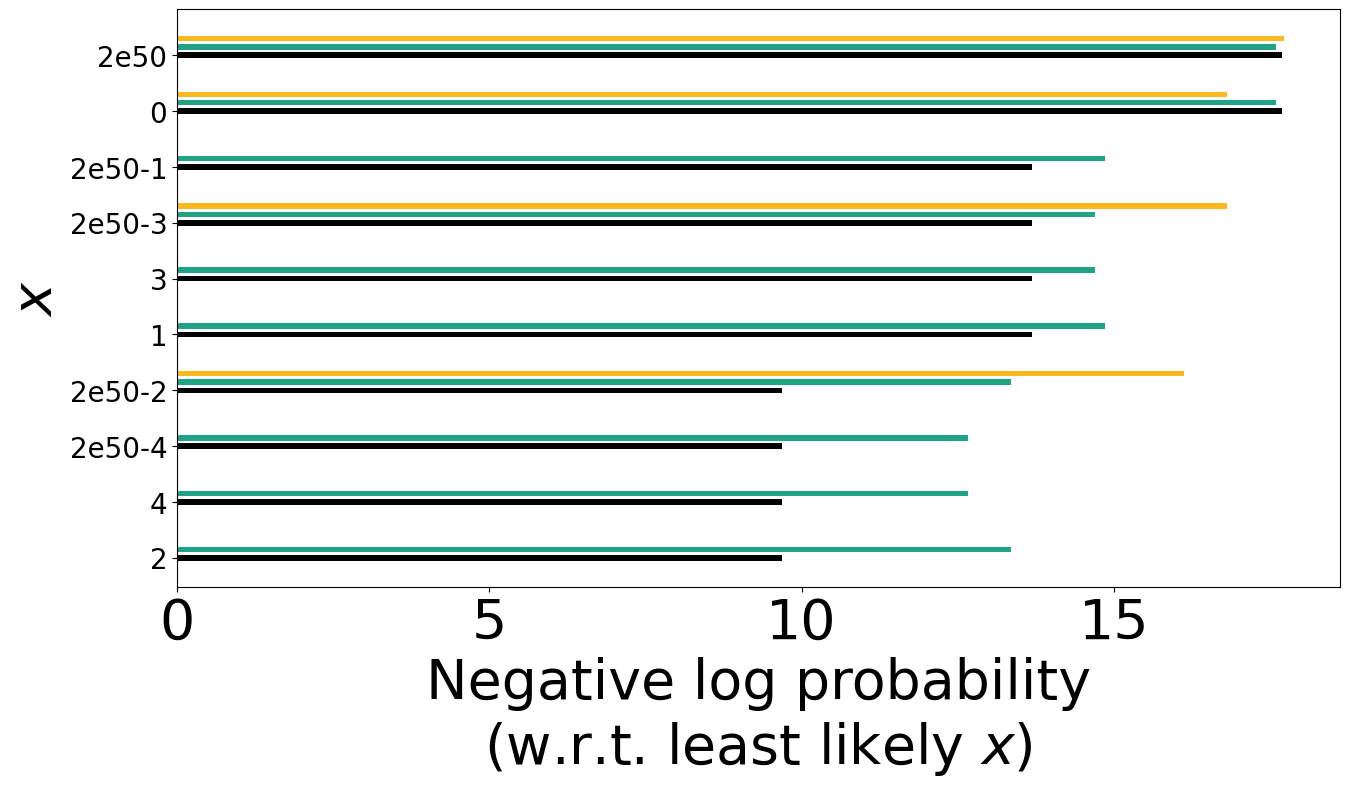

In [43]:
# prbs w.r.t. smallest
smallest=min(np.amin(np.log(weighted_q)),np.amin(np.log(gibbs_density)))
plt_lprbs=np.log(prbs)-smallest
plt_gibbs=np.log(gibbs_density)-smallest
plt_qN=np.log(weighted_q)-smallest

plt.barh(np.arange(0,lprbs.shape[0]),plt_lprbs[sort_idx],height=0.1,label='$\pi(x)$',
        color='black',lw=0)
plt.barh(np.arange(0,lprbs.shape[0])+0.15,plt_qN[sort_idx],height=0.1,label='Mad Mix',
        color='#20A386FF',lw=0)
plt.barh(np.arange(0,lprbs.shape[0])+0.3,plt_gibbs[sort_idx],height=0.1,label='Gibbs',
        color='#FBB91FFF',lw=0)


plt.yticks(ticks=ticks,
           labels=ticks_labs[ticks.astype(int)],
           fontsize=20)
plt.xlabel('Negative log probability\n(w.r.t. least likely $x$)')
plt.ylabel(r'$x$')
#plt.xlim(0.,24.)
#plt.legend(frameon=False,fontsize='small',loc='lower right')
plt.savefig(fig_path+'ising_lprbs.pdf', dpi=300, bbox_inches='tight')

## Save results

In [92]:
# mad mix results
pkl_save(madmix_elbos,'../summary/results/madmix_elbos_ising')
pkl_save(madmix_cput,'../summary/results/madmix_cput_ising')

# gibbs results
pkl_save(gibbs_elbos,'../summary/results/gibbs_elbos_ising')
pkl_save(gibbs_cput,'../summary/results/gibbs_cput_ising')

# concrete results
#concrete_elbos=np.vstack((elbos_onedim,elbos_twodim,elbos_mixture))
#concrete_cpu_times=np.vstack((cpu_times_onedim,cpu_times_twodim,cpu_times_mixture))
concrete_elbos=np.copy(elbos_smallM)
concrete_cpu_times=np.copy(cpu_times_smallM)
pkl_save(concrete_elbos,'../summary/results/concrete_elbos_ising')
pkl_save(concrete_cpu_times,'../summary/results/concrete_cput_ising')

In [27]:
aux.pkl_save(gibbs_density,'gibbs_density')

In [676]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=False # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flowsM     = [0 for i in range(sim_size)]
    lossesM    = np.zeros((sim_size,max_iters))
    cpu_timesM = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(prbs).flatten(),layers=width,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_timesM[i]=time.perf_counter()-t0
            flowsM[i]=tmp_flow
            lossesM[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_timesM.sum())+' seconds')

Done!
Total training time: 31322.71626633199 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

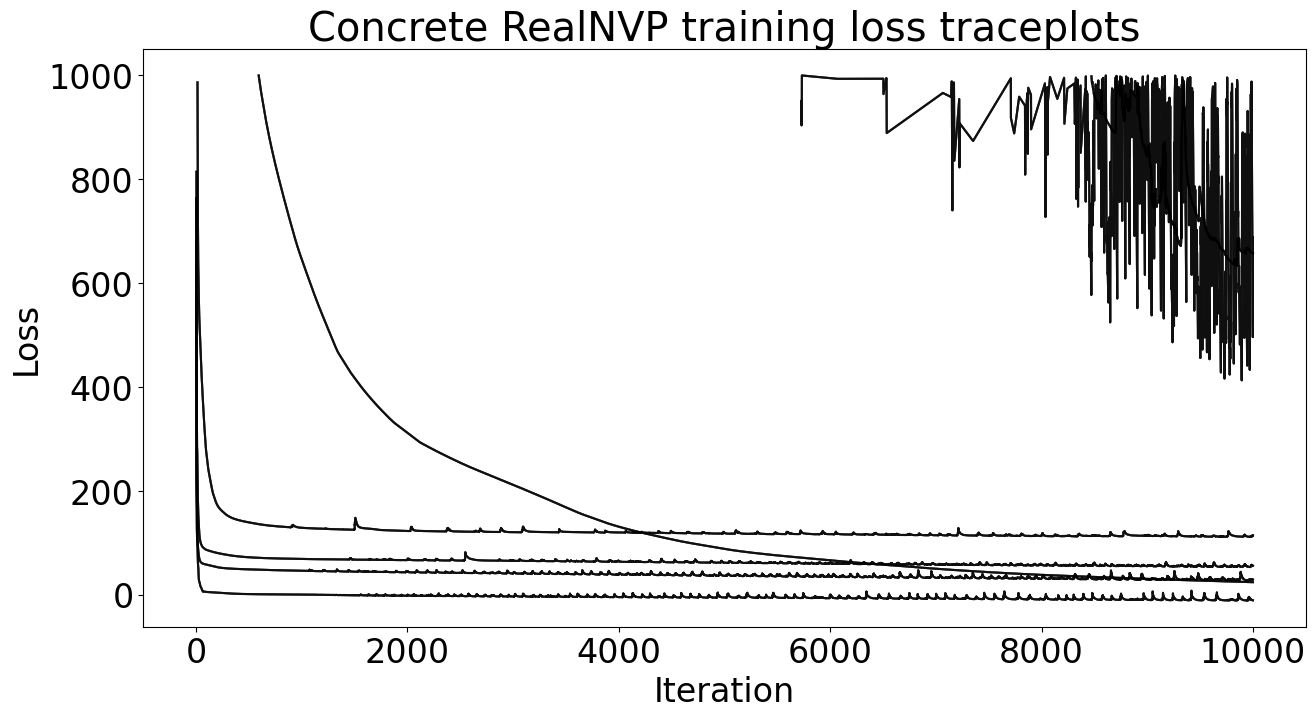

In [677]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[lossesM[i,:]<threshold],lossesM[i,lossesM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [678]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samplesM=np.zeros((sim_size,M,sample_size))
densitiesM=np.zeros((sim_size,2**M))
elbosM=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flowsM[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflattenBinary(tmp_sample,M) # 1d->2d
    samplesM[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample),bins=np.arange(0,2**M+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    tmp_density=tmp_density/np.sum(tmp_density)
    densitiesM[i,:]=tmp_density
    
    # estimate elbo
    elbosM[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/3508441580.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/3508441580.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

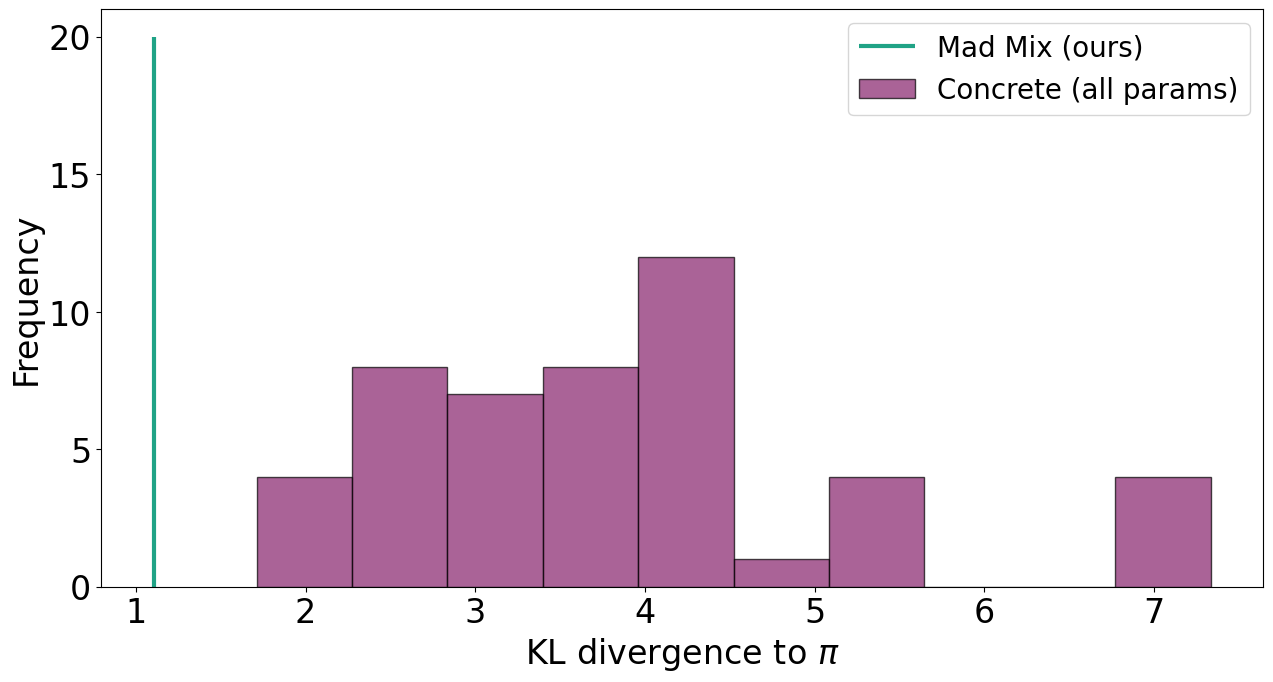

In [679]:
plt.vlines(-elbo_qN,ymin=0,ymax=20,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbosM,bins=10,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)

Text(0, 0.5, 'probability')

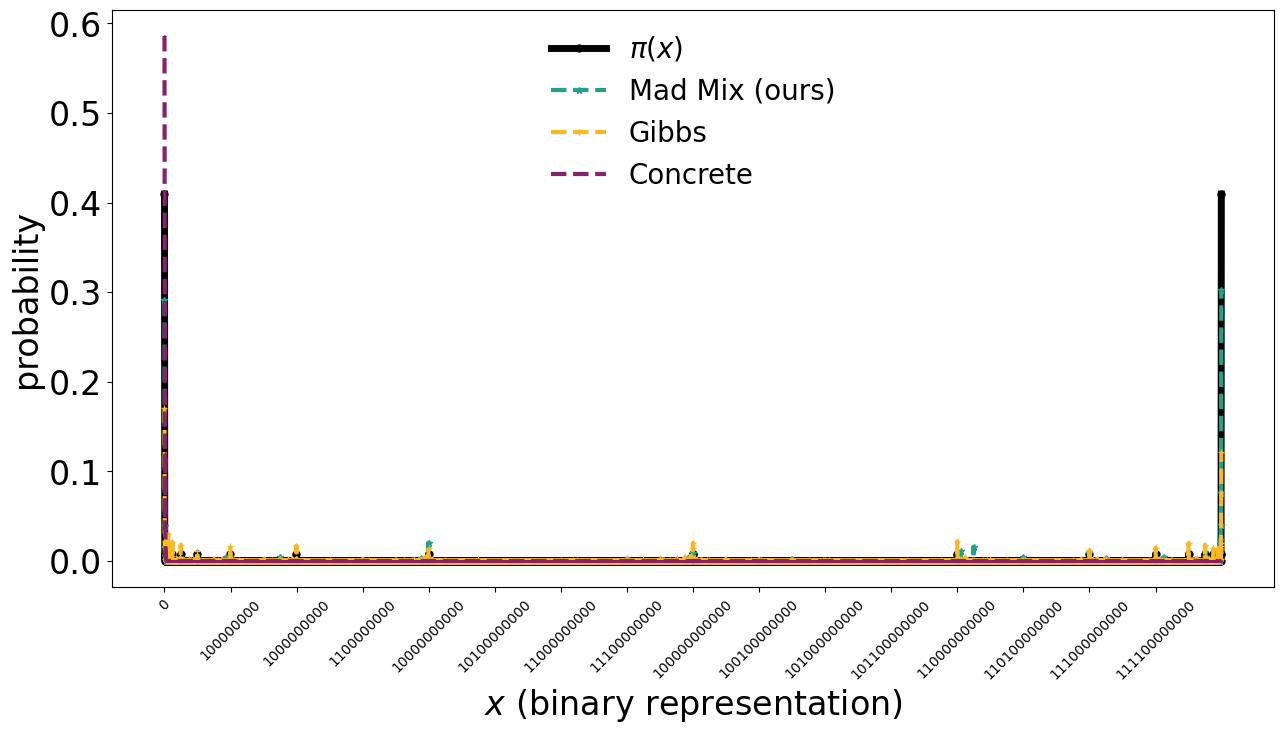

In [680]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,2**M)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=5,marker='o')
plt.plot(ttx+0.5,weighted_q/np.sum(weighted_q),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=5,marker='*')
plt.plot(ttx+0.5,gibbs_density,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=5,marker='+')
plt.plot(ttx+0.5,densitiesM[np.argmax(elbosM),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=1,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x$ (binary representation)')
plt.xticks(ticks=np.arange(0,2**M,step=2**(M-4))+0.5,
           labels=[np.binary_repr(t) for t in np.arange(0,2**M,step=2**(M-4))],
          rotation=45,
          fontsize=10)
plt.ylabel('probability')

In [681]:
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbosM[np.argmax(elbosM)]))

ELBO(qN||π)=-1.1046678345770928
ELBO(qGibbs||π)=-1.4144820292772442
ELBO(qConcrete_opt||π)=-1.7112360917322182


## 1D Ising model with observations

We now take the target $\pi(x)$ from before to be the prior distribution,
and assume we have access to $M$ observations $y_1,\dots,y_M$
that are conditionally independent given $X$.
Specifically, the likelihood is
$$
    L(y\,|\,x)=\prod_{m=1}^M \pi(y_m\,|\,x_m).
$$
The new target is then the posterior distribution
$$
    \pi(x\,|\,y)\propto
    \exp\left\{\sum_{m=1}^{M-1}x_m x_{m+1}\right\}
    \prod_{m=1}^M \pi(y_m\,|\,x_m)
    =\exp\left\{\sum_{m=1}^{M-1}x_m x_{m+1}+\log\pi(y_m\,|\,x_m)\right\}.
$$
As before, the normalization constant is intractable but the full conditionals
can be found in closed form. 
For particles not in the edges, for example,
$$
        \pi_m(x)=\frac{\exp(x(x_{m-1}+x_{m+1})+\log\pi(y_m\,|\,x))}{Z_m},
$$
where
$$
    Z_m=\exp(x_{m-1}+x_{m+1}+\log\pi(y_m\,|\,x=1))+\exp(-x_{m-1}-x_{m+1}+\log\pi(y_m\,|\,x=-1)).
$$
Edge particles are analogous but contain fewer terms since they only have one neighbor.

**Can we create observations that induce multimodality in the posterior?**
Consider, for example, a model such that $y$ is either 0 or 1 (with equal probability)
when $x=-1$ and $y$ is either 1 or 2 (again with equal probability)
when $x=+1$. Formally,
$$
    \pi(y\,|\,x)=
    \begin{cases}
    0.5,& x=-1 \text{ and } y\in\{0,1\},\\
    0.5,& x=+1 \text{ and } y\in\{1,2\},\\
    0,&\text{otherwise}
    \end{cases}.
$$
Then if we observe $M-1$ 0's and a 1, $y=(0,\dots,0,1)$,
we know that $x_1=\cdots=x_{M-1}=-1$,
but $x_M$ can be either -1 or +1.


In [ ]:
#######################
#######################
# model specification #
#######################
#######################
M=5 # number of particles

# data
y_obs=np.zeros(M)
y_obs[-1]=1

# likelihood
def ll(x,axis=None):
    # compute the log likelihood of the Ising model observations
    #
    # inputs:
    #    x    : (M,d) array with state values if axis is None, 
    #            (d,) array with mth state values if axis=m
    # outputs:
    #   ll    : (d,) array with log likelihoods
    
    if axis==None: 
        tmpy=np.repeat(y_obs[:,np.newaxis],x.shape[1],axis=1) # to match x shape
        out=np.log(0.5)*np.ones(x.shape)
        out[(x==-1) & (tmpy==2)]=np.log(1e-32) # impossible combo
        out[(x==1) & (tmpy==0)]=np.log(1e-32)  # impossible combo
        return np.sum(out,axis=0)
    
    # seems like repeated code but arrays below are (d,) dim, not (M,d) dim
    tmpy=y_obs[axis]*np.ones(x.shape)
    out=np.log(0.5)*np.ones(x.shape)
    out[(x==-1) & (tmpy==2)]=np.log(1e-32) # impossible combo
    out[(x==1) & (tmpy==0)]=np.log(1e-32)  # impossible combo
    return out

# target
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: # posterior log joint
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        lpx=np.sum(tmp_x*lag_x,axis=0)
        return lpx+ll(xc,axis=None)
    
    if axis==0: 
        ll0=ll(np.zeros(xc.shape[1])-1,axis=0)
        ll1=ll(np.ones(xc.shape[1]),axis=0)
        logZ=np.log(np.exp(-xc[1,:]+ll0)+np.exp(xc[1,:]+ll1))
        return np.vstack((-xc[1,:]+ll0,xc[1,:]+ll1)).T-logZ[:,np.newaxis]
    if axis==M-1: 
        ll0=ll(np.zeros(xc.shape[1])-1,axis=M-1)
        ll1=ll(np.ones(xc.shape[1]),axis=M-1)
        logZ=np.log(np.exp(-xc[-2,:]+ll0)+np.exp(xc[-2,:]+ll1))
        return np.vstack((-xc[-2,:]+ll0,xc[-2,:]+ll1)).T-logZ[:,np.newaxis]
    if axis>=M: raise Exception("Axis out of bounds")
    ll0=ll(np.zeros(xc.shape[1])-1,axis=axis)
    ll1=ll(np.ones(xc.shape[1]),axis=axis)
    logZ=np.log(np.exp(-xc[axis-1,:]-xc[axis+1,:]+ll0)+\
                np.exp(xc[axis-1,:]+xc[axis+1,:]+ll1))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:]+ll0,\
                      xc[axis-1,:]+xc[axis+1,:]+ll1)).T-logZ[:,np.newaxis]

In [ ]:
########################
########################
#    Mad Mix approx    #
########################
########################
# reference specification
def lq0(x,u):
    xc=2*x-1 # convert to -1,1
    out=np.zeros(xc.shape)
    
    # make sure first M-1 rows are -1
    txc=xc[:-1,:] # all but last row
    tout=out[:-1,:]
    tout[txc==1]=np.log(1e-32)
    out[:-1,:]=tout
    
    # last row can be either -1 or 1 with same prob
    out[-1,:]=np.log(0.5)*np.ones(xc.shape[1])
    return np.sum(out,axis=0)
def randq0(size): 
    tmpx=np.zeros((M,size),dtype=int)
    tmpx[-1,:]=np.random.randint(low=0,high=2,size=(1,size))
    return tmpx,np.random.rand(M,size)

# settings
N=50
n_samples=1000
xi=np.pi/16

In [ ]:
# generate samples
xsamples,usamples=randqN(size=n_samples,N=N,lp=lp,randq0=randq0,xi=xi)

In [ ]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.zeros(M,dtype=int)
x0[-1]=np.random.randint(low=0,high=2)
gibbs_samples=gibbs_sampler(x0=x0,steps=n_samples,lp=lp,burnin_pct=0.9,verbose=True)

In [ ]:
for m in range(usamples.shape[0]): plt.hist(usamples[m,:],density=True,alpha=0.3,ec='black',bins=10)

In [ ]:
jit=0.3 # to jitter scatterplot
xcsamples=2.*xsamples-1. # to transform back to -1,1
#for m in range(M): xcsamples[m,:]=xcsamples[m,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
xcsamples[M-1,:]=xcsamples[M-1,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
df = pd.DataFrame(xcsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

In [ ]:
jit=0.3 # to jitter scatterplot
gibbscsamples=2.*gibbs_samples-1. # to transform back to -1,1
#for m in range(M): gibbscsamples[m,:]=gibbscsamples[m,:]+jit*np.random.rand(gibbscsamples.shape[1])-0.5*jit
df = pd.DataFrame(gibbscsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

In [ ]:
x=np.zeros((M,1),dtype=int)
u=np.random.rand(M,1)
prbs=np.zeros(2)
prbs[0]=np.exp(lqN(x,u,N=100,lq0=lq0,lp=lp,xi=xi))
x[-1,:]=1
prbs[1]=np.exp(lqN(x,u,N=100,lq0=lq0,lp=lp,xi=xi))
prbs=prbs/np.sum(prbs)
print('Estimated probabilities of X=-1 and X=+1 with qN, respectively: '+str(prbs))
gs=gibbs_samples[-1,:]
p1=np.sum(gs)/gs.shape[0]
print('Estimated probabilities of X=-1 and X=+1 with Gibbs, respectively: '+str(np.array([1-p1, p1])))